## NLP lecture 2, comprehension exercises for word distributions

Matthew Stone
Initial version, Spring 2018

[Zipf's Law][1] offers an appealing way to visualize and quantify the skewed distribution of very frequent events and very rare events in linguistic data (and many other kinds of data).

The setup for this exercise recapitulates the visualization tools that we saw in class for exploring Zipf's Law.

[1]:https://en.wikipedia.org/wiki/Zipf%27s_law

In [33]:
from __future__ import print_function 
import math
import nltk
import powerlaw
import collections
import numpy
import matplotlib.pyplot as plt
import scipy.stats as ss
import csv
import pandas as pd
import os
import numpy as np
from collections import Counter
%matplotlib inline
_  = numpy.seterr(divide='ignore', invalid='ignore')

This visualization includes a mode with interactive visualizations with the `plotly` package. They are pretty rewarding, I find, but they are also a little bit slow, because they basically pack a complete corpus into the javascript in the browser. Use them if you like them.

In [2]:
use_plotly = True
if use_plotly:
    import plotly
    import plotly.plotly as py
    import plotly.graph_objs as go
    plotly.offline.init_notebook_mode(connected=True)

We are going to be doing the same computations to visualize the applicability of Zipf's law to a range of data sets, so we create a class Zipf to organize this functionality.

The classic way to visualize Zipf's law is with a scatter plot on a log-log scale. Each item is plotted as a dot at a position  (x,y)(x,y) , where  xx  is its rank (from most common to least common) and  yy  is its actual frequency. Mathematically, you can tell that the data on this kind of scatter plot will all lie on a monotonically decreasing curve: by definition lower ranked entities are more common. However, Zipf's law is reflected in the fact that the curve for linguistic data tends to have a particular shape. In fact, the bulk of the data falls on a line. We'll explain this through examples below. The graph method of a Zipf object displays this graph.

A bunch of other code snippets can be used to help explore a Zipf object z:

- `z.singletons()` a generator function that lists items that occur once in the data set
- `z.n_items_with_rate(k)` count the number of items in the data set that occur k times
- `z.rates.most_common(k)` get a list of the k most common items in the data set
- `z.corr` a matrix giving the correlation coefficient of ranks against log frequencies, typically showing that rank predicts a very large amount of the variance in log frequency.
- `z.describe_singletons()` gives a summary of the frequency of rare events.

To create a `Zipf` object, pass in two arguments: `name` (for labeling graphs), and `rates` (a counter, dictionary or similar structure that associates items with numeric values). The initialization uses the `rankdata` function of scipy to order the items (and reverses the ranks since rankdata goes from lowest to highest), and computes the correlation coefficient. It stores all the results of its computations for later inspection.

In [30]:
class Zipf(object):
    """
    Zipf's law data structure 
    Visualizes the rank-frequency distribution of discrete data
    """
    def __init__(self, name, rates):
        self.name = name
        self.rates = rates
        lowest_to_highest = ss.rankdata([c for (i,c) in rates.items()])
        self.size = len(lowest_to_highest)
        self.ranks = [self.size - r + 1 for r in lowest_to_highest]
        self.rate_data = [c for (i,c) in rates.items()]
        self.labels = [i for (i,c) in rates.items()]
        self.log_data = [math.log(c) for c in self.rate_data]
        self.corr = numpy.corrcoef(self.ranks, self.log_data)
        
    def graph(self):
        plt.figure()
        plt.plot(self.ranks, self.rate_data, 'ro')
        plt.xscale('log')
        plt.xlabel('Frequency rank of item')
        plt.yscale('log')
        plt.ylabel('Number of tokens of item')
        plt.title('Rank-frequency distribution for {}'.format(self.name))

    def graphly(self):
        plotly.offline.iplot(dict(data=[go.Scatter(x=self.ranks,
                                                   y=self.rate_data,
                                                   mode='markers',
                                                   text=self.labels, 
                                                   hoverinfo="text")],
                                  layout=dict(title=u'Rank-frequency distribution for {}'.format(self.name),
                                              xaxis=dict(type='log', title='Frequency rank of item'),
                                              yaxis=dict(type='log', title='Number of tokens of item'))))
            

    def show(self) :
        if use_plotly :
            self.graphly()
        else :
            self.graph()
            
    def singletons(self):
        for (i, c) in self.rates.items():
            if c == 1 :
                yield i
    
    def n_items_with_rate(self, rate):
        return sum(1 for (i, c) in self.rates.iteritems() if c == rate)
    
    def describe_singletons(self):
        print('In {}, {} of {} tokens are singletons.'.format(self.name, 
                                                              self.n_items_with_rate(1),
                                                              self.size))

## Basic Implementation

Find a data set that you're curious about that you think very probably has a Zipf distribution.  Visualize it and see if your hunch is correct.

More precisely, you will have to:
- Load and process the data as necessary to create a counter data structure mapping items to counts.
- Create a Zipf object with based on the counter data structure you have provided.
- Call show() on the resulting object.

Useful sources of data include:
- [Aaron Clauset's archive of power law data sets][1]
- [Project Gutenberg, the premier source of copyright free electronic text][2]
- [US Baby Names][3]   



[1]:http://tuvalu.santafe.edu/~aaronc/powerlaws/data.htm
[2]:https://www.gutenberg.org/
[3]:https://www.ssa.gov/oact/babynames/limits.html

In [31]:
path="D://Rutgers//4th-Semester//Natural_Language_Processing//Assignments//Babynames"
final_name_list=[]
for file  in os.listdir(path):
    if file.endswith(".txt"):
        file_path=os.path.join(path+"//",file)
        with open(file_path,"r") as f:
            for line in f:
                 final_name_list.append(line.split(",")[0])

In [46]:
names_dict = dict()
for i in final_name_list:
    names_dict[i] = names_dict.get(i, 0) + 1

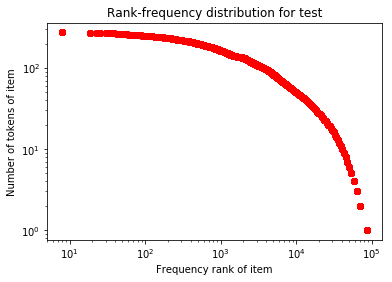

In [50]:
zip_law=Zipf('test',names_dict)
zip_law.graph()

## Advanced Analysis

Apply the statistical tests available in the `powerlaw` package to test how well the data set you have visualized actually fits a power law distribtuion, compared to other heavy tailed distributions.  Use the notebook cells below to carry out and record your analysis (in the code cell) and to summarize and interpret your findings (in the markdown cell).

In [67]:
data=[values for values in sorted(names_dict.values())]
results=powerlaw.Fit(data)
print(results.power_law.alpha) 
print(results.power_law.sigma)
print(results.D)
R, p = results.distribution_compare('power_law', 'lognormal')


Calculating best minimal value for power law fit


2.55113005280206
0.012262759784979383
0.06057215776141567


This does not fit a power law distribution ,as there is no linearity between the rank and the frequency in the data. The Kolomogorov distance between the distribution and divergence is minimal.